The first cell is dedicated to importing libraries. The top part of this cell is for any classes that need to be imported, the middle section is for any data analysis packages, and the last section is more os or time-dependent

In [24]:
#Importing Libraries
import saha_mult #Class used to calculate abundances

import numpy as np
import h5py #useful for skynet files, which are in .hdf5 format
import matplotlib.pyplot as plt
import pandas as pd
import scipy.constants as sc
import pickle #for saving data in lists to txt files.

import os #useful for accessing specific files in directories
from time import process_time #Useful for finding calculation times
import importlib 
importlib.reload(saha_mult) #This command ensures that any changes made to saha_mult class are reflected in this notebook

<module 'saha_mult' from 'D:\\Research\\R-process_Mergers\\Abundance_Calculations\\Total Charge State Abundances\\saha_mult.py'>

This section will detail the numerous functions created for the sake of abundance calculations. 

In [25]:
#The find_nearest function is designed to take as inputs an array of values and a value of interest. 
#From there, it will find the index of the value in the array closest to the value of interst.

def find_nearest(array, value): #Make sure to acknowledge this (from stack overflow)
        array = np.array(array)
        return (np.abs(array - value)).argmin()

In [26]:
#This function here will return all the ionization potentials of the desired elements. 
#Enter the array of elements by their Z value here and the potentials will be returned as an array of arrays.

nist = pd.read_excel("NIST Data Table.xlsx")
ion_energies1d =  nist[' Ionization  Energy (eV)']
kbEvpGK = 8.617e-5*1e9

def ionization_generator(elements):
    max_el = 103 #This is defined to be the Z of the last element that I want in the list 
    ion_energies = list()
    returned_potentials = list()
    counter = 0

    for i in range(0,max_el+1):
        specific_list = list()
        for j in range(i):
            if isinstance(ion_energies1d[counter],str):
                if len(ion_energies1d[counter]) ==3:
                    specific_list.append(0)
                    counter+=1
                else:
                    str_num = '' 
                    for k in ion_energies1d[counter]:
                        if (k != ' ') and (k !='[') and (k !=']') and (k !='(') and (k !=')'):
                            str_num+=k
                    specific_list.append(np.abs(float(str_num)))
                    counter+=1
            else:
                specific_list.append(np.array((np.abs(ion_energies1d[counter]))))
                counter+=1

        ion_energies.append(specific_list)
    ion_energies[-1][-2] = np.average([ion_energies[-1][-1],ion_energies[-1][-3]])
        
    for i in range(len(elements)):
        returned_potentials.append(np.array((ion_energies[elements[i]])))        
        
    return np.array(returned_potentials)

In [27]:
#Calculate the interpolated temperature using a linearized relationship between temp and time in log-log space

def temp_calculator(hf): #load in .hdf5 file
    
    temperature = hf["Temperature"]
    time = hf["Time"]
    
    mod_temp = []
    full_temp = []

    for i in range(1,len(temperature)):
        if temperature[i-1] / temperature[i] ==1:
            index_cut = i-1
            break

    linear = np.polyfit(np.log10(np.array(time[index_cut-300:index_cut])),np.log10(np.array(temperature[index_cut-300:index_cut])),1)
    m = linear[0]

    for i in range(0,len(temperature)):
        if i < index_cut:
            mod_temp.append(np.log10(temperature[i]))
            full_temp.append(temperature[i])
        else:
            del_t = m*(np.log10(time[i]) - np.log10(time[i-1]))
            mod_temp.append(mod_temp[i-1]+del_t)
            full_temp.append(10**mod_temp[i])
    
    return full_temp

In [28]:
#Initialization function designed to calculate elemental abundances 
def initialization(elements,hf):

    abundance = hf["Y"]
    mass = hf["A"]
    charge = hf["Z"]
    
    full_abundance = []
    #ion_potential = ionization_generator(elements)
    
    for i in range(len(elements)):
        temp_index = []
        temp_abundance = []
        
        for j in range(len(charge)):
            
            if charge[j] == (elements[i]): ##charge of element
                temp_index.append(j)
                
        temp_abundance = np.sum(abundance[:, temp_index], 1)
        full_abundance.append(temp_abundance)
        
    return np.array(full_abundance)

In [29]:
#This function is dedicated to the interpolation of skynet data in order to achieve same sizes of data arrays
#Should not be run once interpolated files are generated

def interpolation(directory):
    
    #dedicate this section to setting up interpolation
    
    max_size = 0
    file_number = 1
    
    #directory_Skynet = './Skynet_Files/'
    #directory_Skynet_interpolated = './Skynet_Interpolated_Files/'

    for file in os.listdir(directory):

        hf = h5py.File(directory + file,'r+')
        time = hf['Time']

        if len(time) > max_size:
            max_size = len(time)
            universal_time = time
            
        print(file_number)
        file_number+=1
        
            
    #This part is for interpolation of all Skynet results relative to largest file. This includes linearization of temps
    file_number = 1
    
    for file in os.listdir(directory):
                
        hf = h5py.File(directory + file,'r+')        
        
        #Do interpolations on all data that is dependent on time   
    
        temp = np.interp(universal_time,hf['Time'],hf['Density'])
        del hf['Density']
        hf['Density'] = temp
        
        temp = np.interp(universal_time,hf['Time'],hf['Dt'])
        del hf['Dt']
        hf['Dt'] = temp
        
        temp = np.interp(universal_time,hf['Time'],hf['Entropy'])
        del hf['Entropy']
        hf['Entropy'] = temp
        
        temp = np.interp(universal_time,hf['Time'],hf['EtaE'])
        del hf['EtaE']
        hf['EtaE'] = temp
        
        temp = np.interp(universal_time,hf['Time'],hf['HeatingRate'])
        del hf['HeatingRate']
        hf['HeatingRate'] = temp
        
        temp = np.interp(universal_time,hf['Time'],hf['Temperature'])
        del hf['Temperature']
        hf['Temperature'] = temp
        
        temp = np.interp(universal_time,hf['Time'],hf['Ye'])
        del hf['Ye']
        hf['Ye'] = temp
        
        temp_array = []
        transpose_temp = np.transpose(hf['Y']) #Used transpose for simplicity 
        
        for row in range(np.shape(transpose_temp)[0]):
            
            temp_array.append(np.interp(universal_time,hf['Time'],transpose_temp[row,:]))
            
        del hf['Y']
        hf['Y'] = np.transpose(temp_array) #turn array back to normal, so retranspose  
        
        temp = np.array(universal_time)
        del hf['Time']
        hf['Time'] = temp
        
        temp = np.array(temp_calculator(hf))
        del hf['Temperature']
        hf['Temperature'] = temp
        hf.close()
        
        print('finished with file: ',file_number)
        file_number+=1

In [30]:
#Abundance function to take all variables(for well-mixed ejecta only) 
def abundance_calculation(elements,full_abundance,full_temp,density):
    
    ion_potential = ionization_generator(elements)
    
    return (saha_mult.GetAbundances(np.array(full_abundance),np.array(full_temp),np.array(density),np.array(ion_potential)))

In [31]:
#Abundance function Generic (assumes hf has already been instantiated and only takes in element list )

def abundance_calculation_generic(elements):
    
    abundance = hf["Y"]
    charge = hf["Z"]
    density = hf["Density"]
    Ye_tot = hf['Ye']
    full_temp = hf['Temperature']

    full_abundance = []
    ion_potential = ionization_generator(elements)

    for i in range(len(elements)):
        temp_index = []
        temp_abundance = []

        for j in range(len(charge)):

            if charge[j] == (elements[i]): ##charge of element
                temp_index.append(j)

        temp_abundance = np.sum(abundance[:, temp_index], 1)
        full_abundance.append(temp_abundance)

    return (saha_mult.GetAbundances(np.array(full_abundance),np.array(full_temp),np.array(density),np.array(ion_potential)))

In [32]:
# weighted average function dedicated to a well-mixed ejecta for elemental abundances 

def weighted_average(elements, weights):
    
    #Average over each Ye file
    #Take the shape of any interpolated file's abundance array since the shapes are all the same across various YEs
    
    directory = './Skynet_Interpolated/'
    hf_temp = h5py.File(directory+os.listdir(directory)[0],'r+')
    averaged_elemental = np.zeros((103,len(hf_temp['Time']))) #103 elements of interest by amount of timesteps
    k = 1
    
    for i in range(len(os.listdir(directory))):
        
        hf = h5py.File(directory + os.listdir(directory)[i],'r+')
        temp_elemental = initialization(elements,hf)
        averaged_elemental += weights[i] * temp_elemental
        print('done with',k)
        k+=1
    
    return averaged_elemental

In [33]:
#weighted average function dedicated to a non-mixed ejecta for ionization state abundances
#It will be best to go through each YI by element 

def weighted_average_ionization(directory, weights):
     
    with open(directory + os.listdir(directory)[0], "rb") as fp: 
                YI_temp = pickle.load(fp)
        
    weighted_ionization = [Y * weights[0] for Y in YI_temp] #useful to initialize dimensions of array
    
    for i in range(1,len(os.listdir(directory))):
        
        with open(directory + os.listdir(directory)[i], "rb") as fp: 
                YI = pickle.load(fp)
        
        for j in range(len(YI)):
            
            weighted_ionization[j] += weights[i] * YI[j] #apply weights to each element due to nature of YI shape
    
    return weighted_ionization

In [37]:
#This function will take in a certain ionization abundance file and output graphic of total abundance of a given state
def distribution_ionization(YI,state,full_temp,temp_type = ''): 
    
    lanthanide_names = ['La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu']
    charge_abundances = [] 
    n = 15
    cm = plt.get_cmap('hsv') 

    for i in range(np.shape(YI[70])[1]):
        specific = np.zeros((len(full_temp)))
        for j in range(56,71):
            if i < np.shape(YI[j])[1]:
                specific+=YI[j][:,i]
        charge_abundances.append(specific)

    plt.semilogx(np.array(full_temp),charge_abundances[state],color = 'black',label = 'Total')
    for i in range(0,n,1):
        plt.semilogx(np.array(full_temp),YI[56+i][:,state],label = lanthanide_names[i])
        plt.xlabel("Temp(GK)")
        plt.ylabel("Abundance")
        plt.title('Contributing Ionization State Abundances to +' + str(state) +' State vs Temp:Lanthanides:' + temp_type, y = 1.08)
        plt.xlim([1e-6,1e-5])

    plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5),shadow = True,fancybox = True,title = 'Element',ncol = 5)
    plt.show()


Here are the cells that actually utilize the functions to produce results. Note the cell descriptions at the top for assistance

In [45]:
#This cell is dedicated to calculations of YI for each Ye file that has been interpolated
'''time_start = process_time()

directory_Interpolated = './Skynet_Interpolated/'
directory_Ionization_Interpolated = './Ionization_State_Interpolated_Different_Ye/'
k=1

for filename in os.listdir(directory_Interpolated):
    
    hf = h5py.File(directory_Interpolated + filename)
    YI = abundance_calculation_generic(np.arange(1,104,1))
    
    abundance_file_name = directory_Ionization_Interpolated + 'Charge_Abundance_Interpolated_Ye-'+'{:03d}'.format(k)
    
    with open(abundance_file_name, 'wb') as fp:
        pickle.dump(YI, fp)
    
    k+=1
    
print('This calculation across 50 Ye datasets took:',process_time() - time_start)'''

"time_start = process_time()\n\ndirectory_Interpolated = './Skynet_Interpolated/'\ndirectory_Ionization_Interpolated = './Ionization_State_Interpolated_Different_Ye/'\nk=1\n\nfor filename in os.listdir(directory_Interpolated):\n    \n    hf = h5py.File(directory_Interpolated + filename)\n    YI = abundance_calculation_generic(np.arange(1,104,1))\n    \n    abundance_file_name = directory_Ionization_Interpolated + 'Charge_Abundance_Interpolated_Ye-'+'{:03d}'.format(k)\n    \n    with open(abundance_file_name, 'wb') as fp:\n        pickle.dump(YI, fp)\n    \n    k+=1\n    \nprint('This calculation across 50 Ye datasets took:',process_time() - time_start)"

In [46]:
#The way that the interpolation function is set up, one can only run this once before issues with file formatting and 
#data manipulation start to appear

'''directory_Interpolated = './Skynet_Interpolated/'
hf = h5py.File(directory_Interpolated+os.listdir(directory_Interpolated)[0],'r+')

for key in hf.keys():
    print(hf[key])

#interpolation('./Skynet_Interpolated/')'''

"directory_Interpolated = './Skynet_Interpolated/'\nhf = h5py.File(directory_Interpolated+os.listdir(directory_Interpolated)[0],'r+')\n\nfor key in hf.keys():\n    print(hf[key])\n\n#interpolation('./Skynet_Interpolated/')"

In [47]:
#Do temperature variation checks 

'''directory = './Skynet_Interpolated/'
lanthanide_names = ['La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu']
temps_across_Ye = []
k = 1

for filename in os.listdir(directory):
    hf = h5py.File(directory + filename,'r+')
    time = hf['Time']
    full_temp = hf['Temperature']
    
    temps_across_Ye.append(full_temp[find_nearest(time,86400)]) 
    
    plt.loglog(np.array(time),np.array(full_temp),label = k)
    plt.title('Different Temp vs Time Relations for Various Ye')
    plt.xlabel('Time(sec)')
    plt.ylabel('Temp(GK)')
    k+=1
    
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5),shadow = True,fancybox = True,title = 'Ye Files',ncol = 5)
plt.show()

plt.plot(np.arange(.01,.51,.01),temps_across_Ye)
plt.title('Temps in GK vs Ye at t= 1 day') # REMEMBER to change time if required
pd.DataFrame(temps_across_Ye)'''

"directory = './Skynet_Interpolated/'\nlanthanide_names = ['La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu']\ntemps_across_Ye = []\nk = 1\n\nfor filename in os.listdir(directory):\n    hf = h5py.File(directory + filename,'r+')\n    time = hf['Time']\n    full_temp = hf['Temperature']\n    \n    temps_across_Ye.append(full_temp[find_nearest(time,86400)]) \n    \n    plt.loglog(np.array(time),np.array(full_temp),label = k)\n    plt.title('Different Temp vs Time Relations for Various Ye')\n    plt.xlabel('Time(sec)')\n    plt.ylabel('Temp(GK)')\n    k+=1\n    \nplt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5),shadow = True,fancybox = True,title = 'Ye Files',ncol = 5)\nplt.show()\n\nplt.plot(np.arange(.01,.51,.01),temps_across_Ye)\nplt.title('Temps in GK vs Ye at t= 1 day') # REMEMBER to change time if required\npd.DataFrame(temps_across_Ye)"

In [48]:
#This cell is dedicated to extracting the ionization abundances for a well-mixed ejecta given certain weights
time_start = process_time()

weights = np.concatenate((np.zeros(4),(1/34)*np.ones(34),np.zeros(12))) #based on Radice and Roberts Kilonova paper
averaged_elemental = weighted_average(np.arange(1,104,1),weights)

#With the averaged elemental abundances calculated, we proceed to ionization_abundance calculations
#For the low temperature case at t=1 day, the Ye corresponding Ye for the given weight range is Ye = .24

hf_low = h5py.File('./Skynet_Interpolated/SkyNet_r-process_0.240000.h5','r+')
low_ionization = abundance_calculation(np.arange(1,104,1),averaged_elemental,hf_low['Temperature'],hf_low['Density'])

#For the high temperature case at t=1 day, the Ye corresponding Ye for the given weight range is Ye = .38

hf_high = h5py.File('./Skynet_Interpolated/SkyNet_r-process_0.380000.h5','r+')
high_ionization = abundance_calculation(np.arange(1,104,1),averaged_elemental,hf_high['Temperature'],hf_high['Density'])

done with 1
done with 2
done with 3
done with 4
done with 5
done with 6
done with 7
done with 8
done with 9
done with 10
done with 11
done with 12
done with 13
done with 14
done with 15
done with 16
done with 17
done with 18
done with 19
done with 20
done with 21
done with 22
done with 23
done with 24
done with 25
done with 26
done with 27
done with 28
done with 29
done with 30
done with 31
done with 32
done with 33
done with 34
done with 35
done with 36
done with 37
done with 38
done with 39
done with 40
done with 41
done with 42
done with 43
done with 44
done with 45
done with 46
done with 47
done with 48
done with 49
done with 50


D:\Research\R-process_Mergers\Abundance_Calculations\Total Charge State Abundances\saha_mult.py:137: RuntimeWarning: divide by zero encountered in log
  fLow = np.log(GetYefContribution(Ytot, T9, rho, lnYefLow, xi)) - lnYefLow
D:\Research\R-process_Mergers\Abundance_Calculations\Total Charge State Abundances\saha_mult.py:138: RuntimeWarning: divide by zero encountered in log
  fHi = np.log(GetYefContribution(Ytot, T9, rho, lnYefHi, xi)) - lnYefHi
D:\Research\R-process_Mergers\Abundance_Calculations\Total Charge State Abundances\saha_mult.py:149: RuntimeWarning: divide by zero encountered in log
  fMid = np.log(GetYefContribution(Ytot, T9, rho, lnYefMid, xi)) - lnYefMid


In [15]:
#Also involve temperatures and densities that are averaged across the 50 Ye files
#well-mixed
#Implemented temperature averaging scheme involving sums over the energies followed by taking the 4th root to get T_avg

directory = './Skynet_Interpolated/'
weights = np.concatenate((np.zeros(4),(1/34)*np.ones(34),np.zeros(12))) #based on Radice and Roberts Kilonova paper
averaged_elemental = weighted_average(np.arange(1,104,1),weights)

sum_temp = 0
sum_density = 0

for i in range(len(weights)):
    
    hf = h5py.File(directory + os.listdir(directory)[0],'r+')
    sum_temp+= ((weights[i] * sc.Stefan_Boltzmann * np.array(hf['Temperature'])**4) / np.array(hf['Density'])) **.25
    sum_density+= (weights[i] * np.array(hf['Density']))

averaged_temperatures = sum_temp * sum_density
average_ionization = abundance_calculation(np.arange(1,104,1),averaged_elemental,averaged_temperatures,sum_density)

'''
directory = './Skynet_Interpolated/'
hf_temp = h5py.File(directory+os.listdir(directory)[0],'r+')
averaged_temperatures = np.zeros(len(hf_temp['Temperature']))
averaged_densities = np.zeros(len(hf_temp['Density']))

for i in range(len(os.listdir(directory))):
    hf = h5py.File(directory + os.listdir(directory)[i],'r+')
    averaged_temperatures += weights[i] * np.array(hf['Temperature'])
    averaged_densities += weights[i] * np.array(hf['Density'])

average_ionization = abundance_calculation(np.arange(1,104,1),averaged_elemental,averaged_temperatures,averaged_densities)'''

done with 1
done with 2
done with 3
done with 4
done with 5
done with 6
done with 7
done with 8
done with 9
done with 10
done with 11
done with 12
done with 13
done with 14
done with 15
done with 16
done with 17
done with 18
done with 19
done with 20
done with 21
done with 22
done with 23
done with 24
done with 25
done with 26
done with 27
done with 28
done with 29
done with 30
done with 31
done with 32
done with 33
done with 34
done with 35
done with 36
done with 37
done with 38
done with 39
done with 40
done with 41
done with 42
done with 43
done with 44
done with 45
done with 46
done with 47
done with 48
done with 49
done with 50


NameError: name 'averaged_densities' is not defined

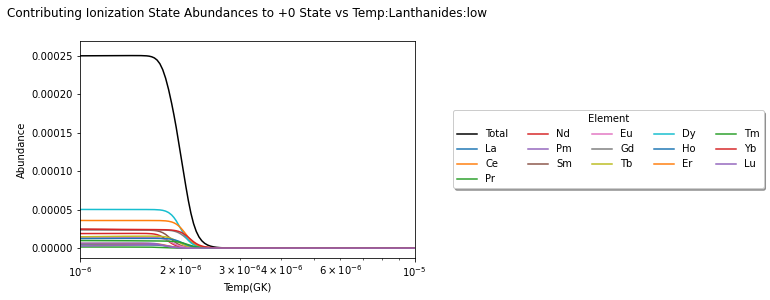

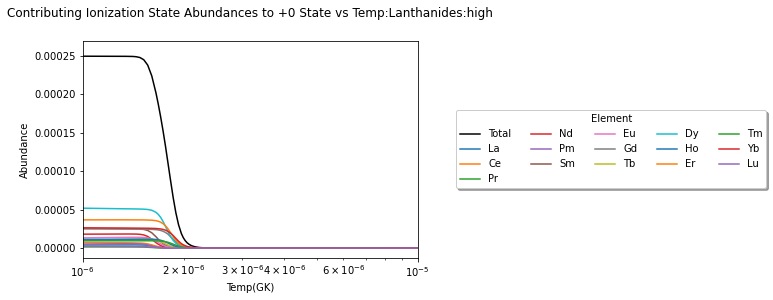

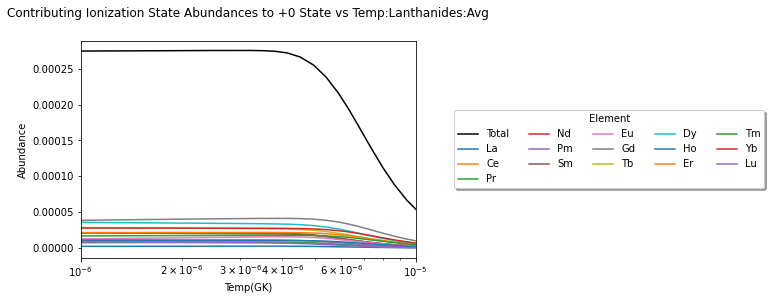

In [49]:
#Cell for ionization abundance plots for +0 state
#well-mixed

distribution_ionization(low_ionization, 0,hf_low['Temperature'],'low') #low
distribution_ionization(high_ionization, 0,hf_high['Temperature'],'high') #high
distribution_ionization(average_ionization, 0,averaged_temperatures,'Avg') #average

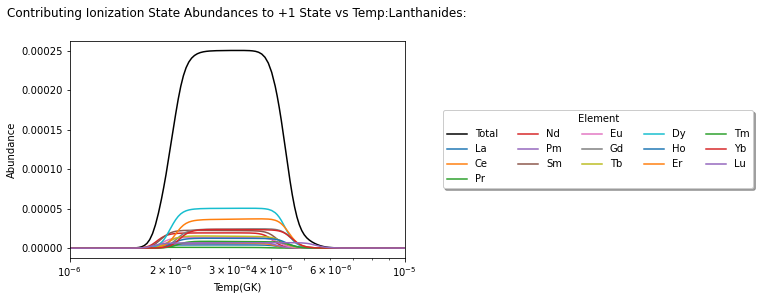

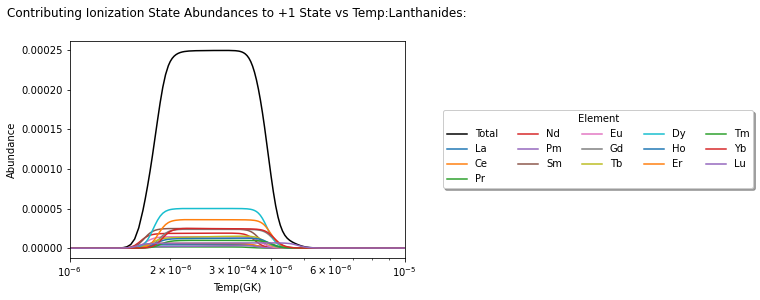

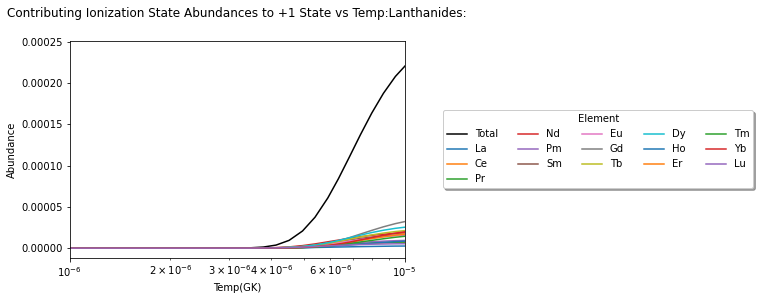

In [50]:
#Cell for ionization abundance plots for +1 state
#well-mixed

distribution_ionization(low_ionization, 1,hf_low['Temperature']) #low
distribution_ionization(high_ionization, 1,hf_high['Temperature']) #high
distribution_ionization(average_ionization, 1,averaged_temperatures) #average

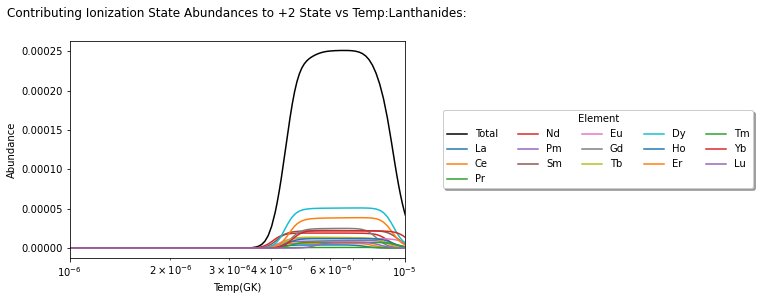

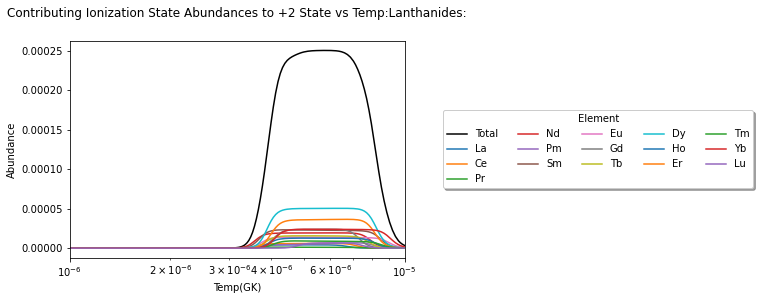

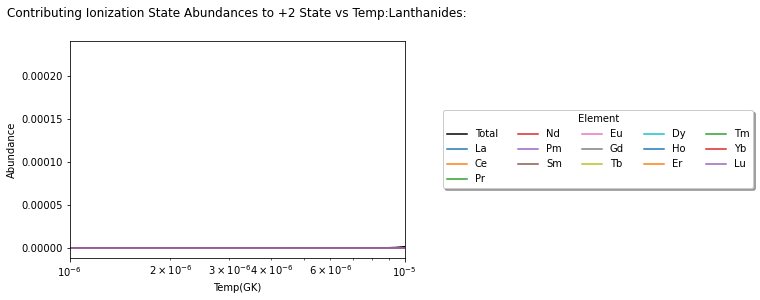

In [51]:
#Cell for ionization abundance plots for +2 state
#well-mixed

distribution_ionization(low_ionization, 2,hf_low['Temperature']) #low
distribution_ionization(high_ionization, 2,hf_high['Temperature']) #high
distribution_ionization(average_ionization, 2,averaged_temperatures) #average

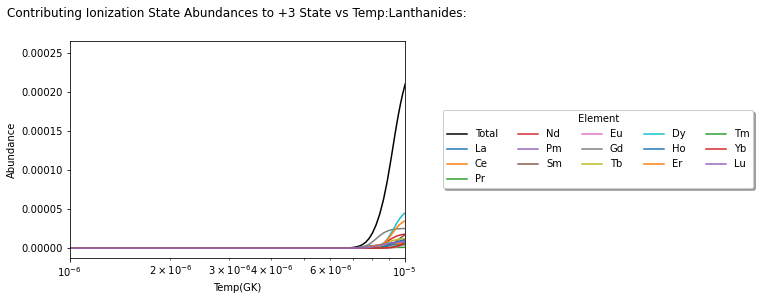

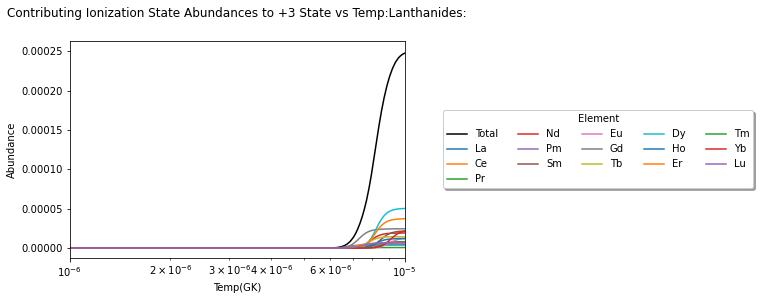

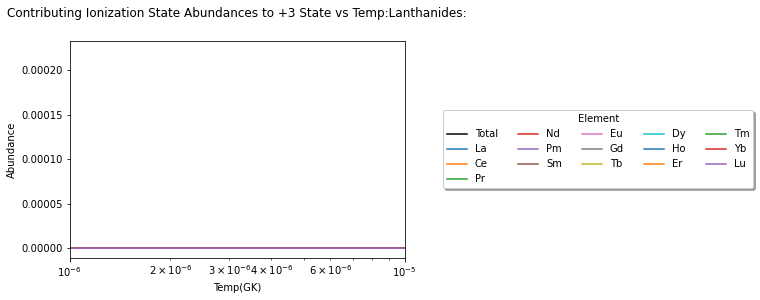

In [52]:
#Cell for ionization abundance plots for +3 state
#well-mixed

distribution_ionization(low_ionization, 3,hf_low['Temperature']) #low
distribution_ionization(high_ionization, 3,hf_high['Temperature']) #high
distribution_ionization(average_ionization, 3,averaged_temperatures) #average

In [69]:
#This cell will be used to make the weighted_average calculation for the unmixed ejecta as well as plot the dist_abun plots
#With this Yi, plug into a modified form of distribution_ionization()

directory_ionization_Interpolated = './Ionization_State_Interpolated_Different_Ye/'
directory = './Skynet_Interpolated/'

weights = np.concatenate((np.zeros(4),(1/34)*np.ones(34),np.zeros(12))) #based on Radice and Roberts Kilonova paper
hf_temp = h5py.File(directory+os.listdir(directory)[0],'r+')
weighted_average = weighted_average_ionization(directory_ionization_Interpolated,weights) #for averaged ionization state abundances

averaged_temperatures = np.zeros(len(hf_temp['Temperature']))
averaged_densities = np.zeros(len(hf_temp['Density']))

for i in range(len(os.listdir(directory))):
    
    hf = h5py.File(directory + os.listdir(directory)[i],'r+')
    averaged_temperatures += weights[i] * np.array(hf['Temperature'])
    averaged_densities += weights[i] * np.array(hf['Density'])
    


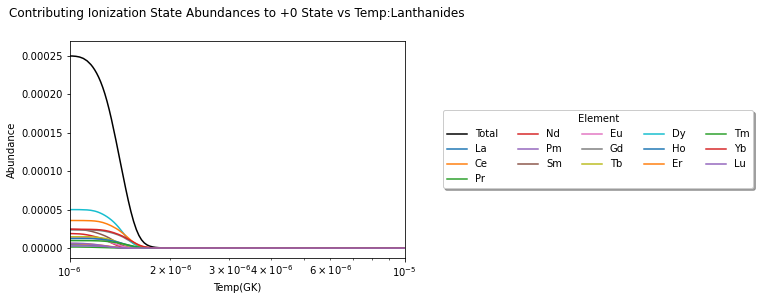

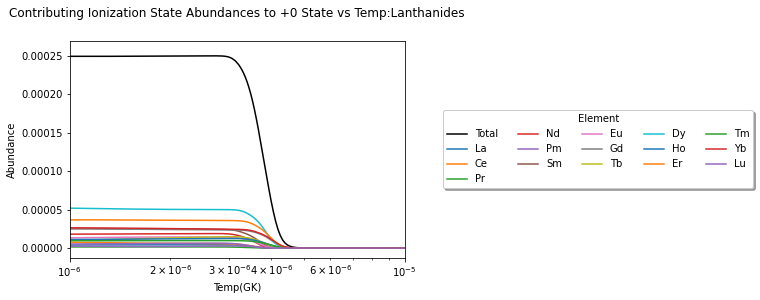

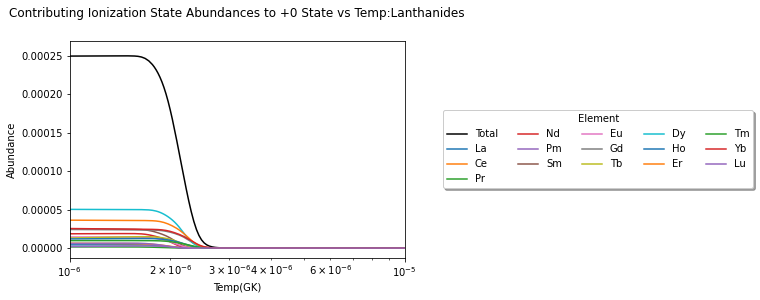

In [73]:
#This cell is for finding the distribution of the ionization abundances for the unmixed ejecta case.

full_temp_low = h5py.File('./Skynet_Interpolated/SkyNet_r-process_0.240000.h5','r+')['Temperature'] #low temps
full_temp_high = h5py.File('./Skynet_Interpolated/SkyNet_r-process_0.380000.h5','r+')['Temperature']

distribution_ionization(weighted_average,0,full_temp_low) #low case
distribution_ionization(weighted_average,0,full_temp_high) #high case
distribution_ionization(weighted_average,0,averaged_temperatures) #avg temp case